In [1]:
import os
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/Уфа ИИ/dataset2/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [4]:
# задаем преобразование изображения.
img_size=(224, 224)

train_transform = transforms.Compose([
    transforms.Resize(img_size),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(img_size),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [5]:
data_df = pd.read_csv("/content/drive/MyDrive/Уфа ИИ/Копия train_0_0_0.csv")

In [6]:
len(data_df)

1328

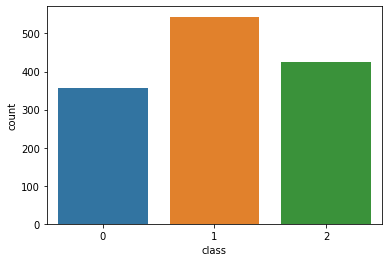

In [ ]:
import seaborn as sns
import warnings
 
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

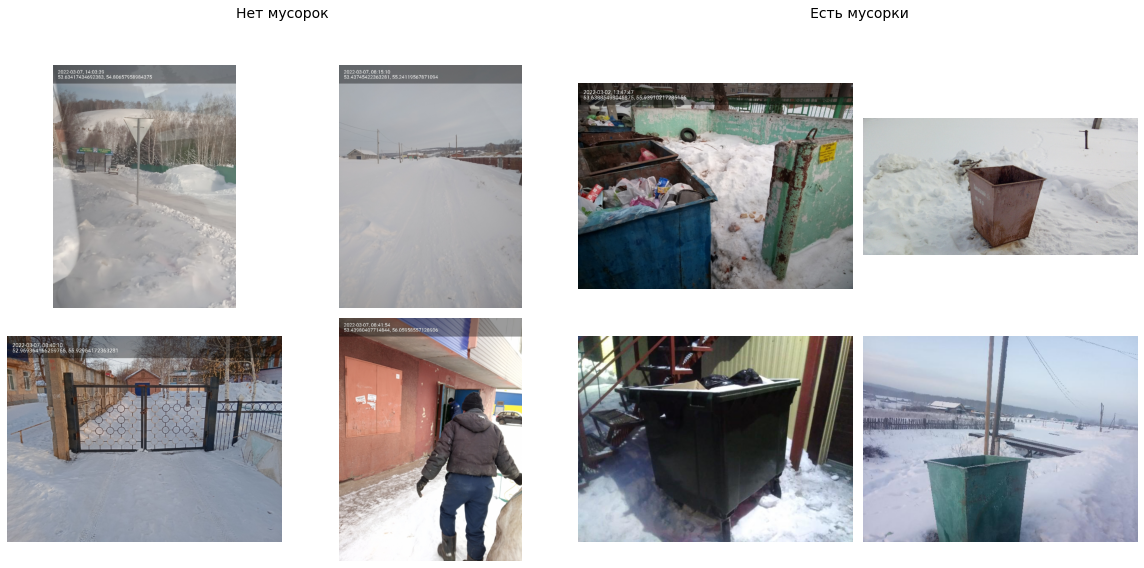

In [ ]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Нет мусорок {" "*105} Есть мусорки', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"/content/drive/MyDrive/Уфа ИИ/dataset2/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"/content/drive/MyDrive/Уфа ИИ/dataset2/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [7]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.35, random_state=42)

In [8]:
train_df.shape, valid_df.shape

((863, 2), (465, 2))

In [9]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)


## Вспомогательные функции

In [21]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
    
    return train_score,val_score

In [22]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [46]:
# optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)

resnet18

optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)

In [47]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 50)

100%|██████████| 50/50 [17:11<00:00, 20.62s/it]

Train loss: 0.13169484474153398
Val loss: 0.26314854942342286
Train acc: tensor(98.2619, device='cuda:0')
Val acc: tensor(94.4086, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

# Предскажем для теста

In [48]:
test_df = pd.read_csv("/content/drive/MyDrive/Уфа ИИ/train_dataset_train/sample_solution.csv")

In [49]:
test_df = test_df.drop(["class"], axis = 1)

In [50]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        image_name=image_name+'.jpg'


                
        # читаем картинку
        image = cv2.imread(f"/content/drive/MyDrive/Уфа ИИ/test_dataset_test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [51]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [52]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#Предсказываем нашей моделью результат

In [53]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()
    
    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)
    
    #predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


In [54]:
test_names=test_df['ID_img'].tolist()

In [55]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts)], columns=['ID_img', 'class'])

In [56]:
submit_df.to_csv("submit4.csv", index=False)

In [ ]:
submit_df

,ID_img,class
0,34020749806_42065966214_42113475048_2,1
1,80128313599_98196458454_79029076007_8,1
2,17820331238_48919943775_53688855463_7,2
3,70492442702_21083599816_22777758696_0,1
4,94790217016_17108156014_60668676818_2,2
...,...,...
220,60879177998_15763718934_82574532042_2,2
221,11758169966_65799840524_72283028069_1,1
222,9259096884_2251720133_44072689872_8,1
223,37732252922_9265441355_19052721018_3,1


Score = 0.871227